In [3]:
import pandas as pd
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
df = pd.read_csv("output_random.csv")
df = df[['Consumer complaint narrative', 'Product']].dropna()
mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Credit reporting or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}

In [5]:
df = df[df['Product'].isin(mapping.keys())]
df['Category'] = df['Product'].map(mapping)

In [6]:
def clean_text(t):
    t = t.lower()
    t = re.sub(r"\d+", "", t)
    t = t.translate(str.maketrans("", "", string.punctuation))
    t = re.sub(r"\s+", " ", t)
    return t.strip()

df['CleanText'] = df['Consumer complaint narrative'].apply(clean_text)

X = df['CleanText']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
vectorizer = CountVectorizer(stop_words='english', max_features=4000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [8]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1),
    "SVM": LinearSVC(max_iter=3000),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=150, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    results[name] = (acc, preds)
    print(name, "Accuracy:", round(acc, 4))
    print(classification_report(y_test, preds, target_names=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"]))

RandomForest Accuracy: 0.93
                  precision    recall  f1-score   support

Credit Reporting       0.94      0.99      0.96      7719
 Debt Collection       0.87      0.66      0.75      1291
   Consumer Loan       0.00      0.00      0.00        29
        Mortgage       0.93      0.80      0.86       474

        accuracy                           0.93      9513
       macro avg       0.69      0.61      0.64      9513
    weighted avg       0.93      0.93      0.92      9513



C:\Users\riyak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\riyak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\riyak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

SVM Accuracy: 0.9089
                  precision    recall  f1-score   support

Credit Reporting       0.94      0.96      0.95      7719
 Debt Collection       0.73      0.66      0.69      1291
   Consumer Loan       0.24      0.14      0.17        29
        Mortgage       0.89      0.80      0.84       474

        accuracy                           0.91      9513
       macro avg       0.70      0.64      0.66      9513
    weighted avg       0.90      0.91      0.91      9513

GradientBoosting Accuracy: 0.9216
                  precision    recall  f1-score   support

Credit Reporting       0.94      0.98      0.96      7719
 Debt Collection       0.83      0.65      0.73      1291
   Consumer Loan       0.23      0.17      0.20        29
        Mortgage       0.91      0.82      0.86       474

        accuracy                           0.92      9513
       macro avg       0.72      0.65      0.68      9513
    weighted avg       0.92      0.92      0.92      9513



In [9]:
best_model = max(results, key=lambda k: results[k][0])
best_preds = results[best_model][1]
print("Best model:", best_model)

Best model: RandomForest


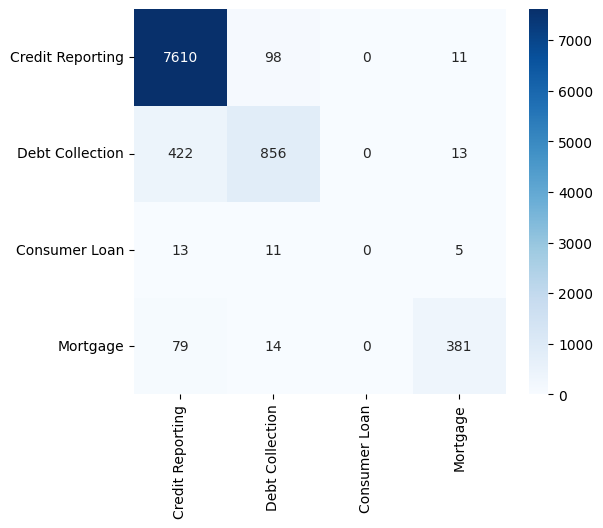

In [10]:
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"], yticklabels=["Credit Reporting","Debt Collection","Consumer Loan","Mortgage"])
plt.show()

In [11]:
sample_idx = random.sample(range(len(X_test)), 10)
sample_texts = X_test.iloc[sample_idx]
sample_true = y_test.iloc[sample_idx]
sample_vec = vectorizer.transform(sample_texts)
sample_preds = models[best_model].predict(sample_vec)

for t, true, pred in zip(sample_texts, sample_true, sample_preds):
    print("Complaint:", t[:120], "...")
    print("True:", true, "Pred:", pred, "\n")

Complaint: i have not supplied proof under the doctrine of estoppel by silence engelhardt v gravens mo sw i pressume that no proof  ...
True: 0 Pred: 0 

Complaint: dear to whom it may concern i recently pulled up my xxxx report and i noticed a derogatory remark on there under usc cc  ...
True: 1 Pred: 0 

Complaint: xxxx xxxx xxxx xxxx has charged off this debt to the irs i never received a c or proof of my securitization where this p ...
True: 0 Pred: 0 

Complaint: i am writing to have the following information removed from my credit file the items that i need deleted are going to be ...
True: 0 Pred: 0 

Complaint: i xxxx xxxx entered into a consumer credit transaction with nissan xxxx xxxx on xxxx a consumer credit transaction in wh ...
True: 1 Pred: 1 

Complaint: xxxxxxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx fl xxxx email xxxx phone xxxx xxxx xxxx transunion consumer soluti ...
True: 0 Pred: 0 

Complaint: i am a xxxx at same time so we are so busy and this companydebt c